In [ ]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Exploratory Data Analysis

The following are the columns' meanings:

Gender - Gender of the individual.

family_history_with_overweight - Whether a family member suffered or suffers from overweight.

FAVC - Frequent consumption of high caloric food.

FCVC - Frequency of consumption of vegetables.

NCP - Number of main meals.

CAEC - Consumption of food between meals.

SMOKE - Whether the individual is a smoker or not.

CH2O - Consumption of water daily.

SCC - Whether the individual monitors calories consumption.

FAF - Physical activity frequency.

TUE - Time using technology devices.

CALC - Consumption of alcohol.

MTRANS - Transportation used.

NObeyesdad - Obesity level deducted from individual measurements.

In [2]:
df = pd.read_csv("dataset/train.csv")
df.head

<bound method NDFrame.head of           id  Gender        Age    Height      Weight  \
0          0    Male  24.443011  1.699998   81.669950   
1          1  Female  18.000000  1.560000   57.000000   
2          2  Female  18.000000  1.711460   50.165754   
3          3  Female  20.952737  1.710730  131.274851   
4          4    Male  31.641081  1.914186   93.798055   
...      ...     ...        ...       ...         ...   
20753  20753    Male  25.137087  1.766626  114.187096   
20754  20754    Male  18.000000  1.710000   50.000000   
20755  20755    Male  20.101026  1.819557  105.580491   
20756  20756    Male  33.852953  1.700000   83.520113   
20757  20757    Male  26.680376  1.816547  118.134898   

      family_history_with_overweight FAVC      FCVC       NCP        CAEC  \
0                                yes  yes  2.000000  2.983297   Sometimes   
1                                yes  yes  2.000000  3.000000  Frequently   
2                                yes  yes  1.880534  1

In [ ]:
# Sanity check
print("\nMissing values per column:\n")
print(df.isnull().sum())


Missing values per column:

id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


In [4]:
# Count the number of unique values in each column
unique_values = df.nunique()

print("Number of Unique Values in Each Column:\n")
print(unique_values)

Number of Unique Values in Each Column:

id                                20758
Gender                                2
Age                                1703
Height                             1833
Weight                             1979
family_history_with_overweight        2
FAVC                                  2
FCVC                                934
NCP                                 689
CAEC                                  4
SMOKE                                 2
CH2O                               1506
SCC                                   2
FAF                                1360
TUE                                1297
CALC                                  3
MTRANS                                5
NObeyesdad                            7
dtype: int64


In [5]:
# Separate categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

categorical_cols, numerical_cols

(Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
        'SCC', 'CALC', 'MTRANS', 'NObeyesdad'],
       dtype='object'),
 Index(['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object'))

In [6]:
unique_labels = df['NObeyesdad'].unique()
label_count = len(unique_labels)

print("Number of unique labels:", label_count)
print("Labels:", unique_labels)

Number of unique labels: 7
Labels: ['Overweight_Level_II' 'Normal_Weight' 'Insufficient_Weight'
 'Obesity_Type_III' 'Obesity_Type_II' 'Overweight_Level_I'
 'Obesity_Type_I']


In [7]:
class_counts = df['NObeyesdad'].value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
 NObeyesdad
Obesity_Type_III       4046
Obesity_Type_II        3248
Normal_Weight          3082
Obesity_Type_I         2910
Insufficient_Weight    2523
Overweight_Level_II    2522
Overweight_Level_I     2427
Name: count, dtype: int64


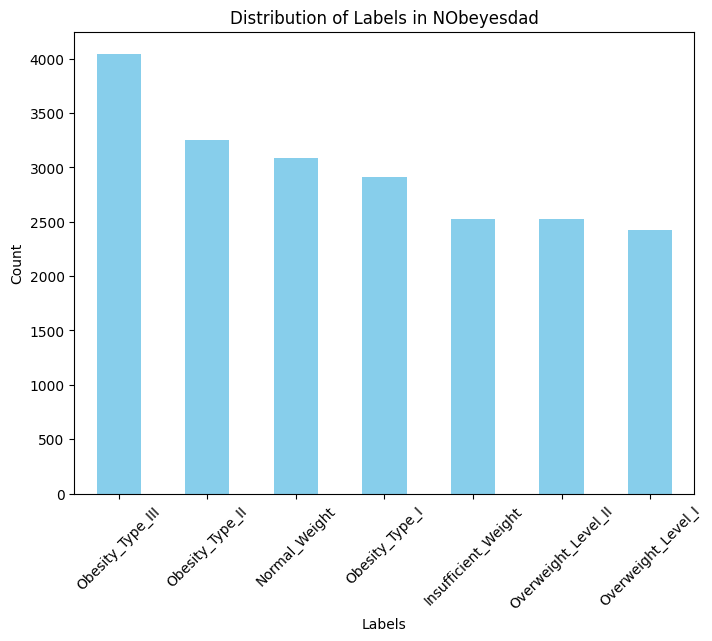

In [8]:
# Visualize class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Labels in NObeyesdad')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

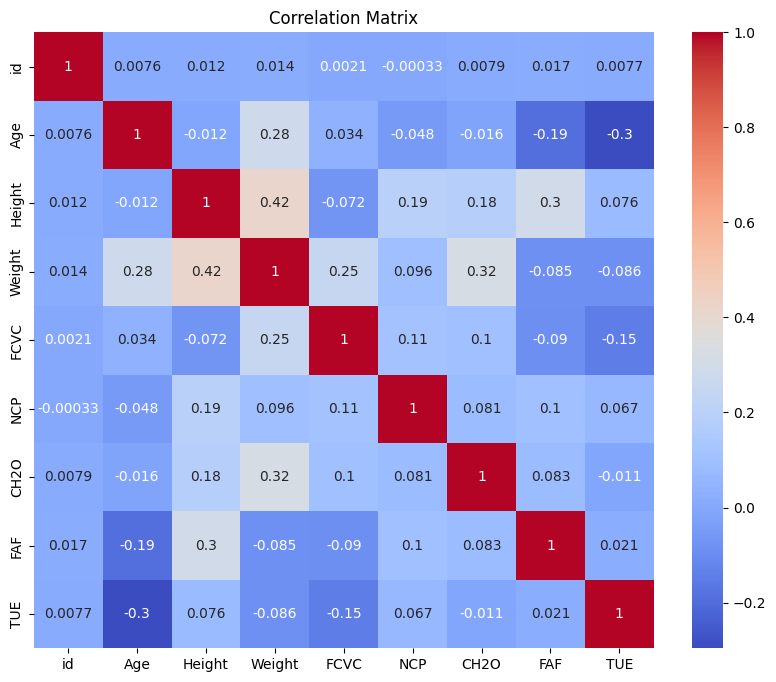

In [9]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Could consider setting different class weights

## Preprocessing

In [10]:
df = df.drop(columns=['id'])
df.fillna(0, inplace=True)

In [11]:
# Label encode binary columns
binary_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
label_encoders = {col: LabelEncoder() for col in binary_columns}

for col in binary_columns:
    df[col] = label_encoders[col].fit_transform(df[col])

In [12]:
# One-hot encode non-binary categorical columns
one_hot_columns = ['CAEC', 'CALC', 'MTRANS']
df = pd.get_dummies(df, columns=one_hot_columns, drop_first=True)
df = df.astype({col: int for col in df.select_dtypes(include=['bool']).columns})

In [13]:
# Encode the target variable
target_encoder = LabelEncoder()
df['NObeyesdad'] = target_encoder.fit_transform(df['NObeyesdad'])

In [14]:
# example
print(df.iloc[0])

Gender                             1.000000
Age                               24.443011
Height                             1.699998
Weight                            81.669950
family_history_with_overweight     1.000000
FAVC                               1.000000
FCVC                               2.000000
NCP                                2.983297
SMOKE                              0.000000
CH2O                               2.763573
SCC                                0.000000
FAF                                0.000000
TUE                                0.976473
NObeyesdad                         6.000000
CAEC_Frequently                    0.000000
CAEC_Sometimes                     1.000000
CAEC_no                            0.000000
CALC_Sometimes                     1.000000
CALC_no                            0.000000
MTRANS_Bike                        0.000000
MTRANS_Motorbike                   0.000000
MTRANS_Public_Transportation       1.000000
MTRANS_Walking                  

In [15]:
# Save mappings for the target variable
class_mappings = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
print("\nTarget Variable Mappings:", class_mappings)


Target Variable Mappings: {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6}


In [16]:
# Add BMI feature to the dataset
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Update numerical columns list
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']

In [17]:
# Add BMI feature to the dataset
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Update numerical columns list
numerical_columns = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI']
scaler = StandardScaler()
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])  # Normalize entire dataset

In [18]:
# Example
print("First row of the DataFrame:\n")
print(df.iloc[0])

First row of the DataFrame:

Gender                            1.000000
Age                               0.105699
Height                           -0.002828
Weight                           -0.235713
family_history_with_overweight    1.000000
FAVC                              1.000000
FCVC                             -0.836279
NCP                               0.314684
SMOKE                             0.000000
CH2O                              1.206594
SCC                               0.000000
FAF                              -1.171141
TUE                               0.597438
NObeyesdad                        6.000000
CAEC_Frequently                   0.000000
CAEC_Sometimes                    1.000000
CAEC_no                           0.000000
CALC_Sometimes                    1.000000
CALC_no                           0.000000
MTRANS_Bike                       0.000000
MTRANS_Motorbike                  0.000000
MTRANS_Public_Transportation      1.000000
MTRANS_Walking           

In [19]:
X = df.drop(columns=['NObeyesdad'])
y = df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

Training set size: 16606 samples
Test set size: 4152 samples


In [20]:
# Class distribution
class_counts = y.value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
 NObeyesdad
4    4046
3    3248
1    3082
2    2910
0    2523
6    2522
5    2427
Name: count, dtype: int64


In [21]:
# Compute class weights
import torch

class_weights = 1.0 / torch.tensor(class_counts.values, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() 

print("Class Weights:", class_weights)

Class Weights: tensor([0.1018, 0.1268, 0.1336, 0.1415, 0.1632, 0.1633, 0.1697])


In [22]:
X_train.shape, X_test.shape

((16606, 23), (4152, 23))

In [23]:
y_train.shape, y_test.shape

((16606,), (4152,))

# Model Initizalization

In [24]:
class ObesityClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(ObesityClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(p=0.25)
        self.fc3 = nn.Linear(64, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)  # Output logits
        return x

# Initialize the model
input_size = X_train.shape[1]  # Number of features
output_size = len(y.unique())  # Number of classes
model = ObesityClassifier(input_size, output_size)

# Print model architecture
print(model)       

ObesityClassifier(
  (fc1): Linear(in_features=23, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=64, out_features=7, bias=True)
)


# Training 

In [25]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [26]:
print(X_train_tensor.shape)  # (num_samples, num_features)
print(y_train_tensor.shape)  # (num_samples,)

torch.Size([16606, 23])
torch.Size([16606])


In [27]:
# Create DataLoader for batching
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() 
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch) 
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader)) 
    
    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, y_test_tensor).item()
        test_losses.append(test_loss)
        
    # Step the scheduler
    scheduler.step()
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

Epoch 1/50, Train Loss: 0.7000, Test Loss: 0.4138
Epoch 2/50, Train Loss: 0.4532, Test Loss: 0.3812
Epoch 3/50, Train Loss: 0.4257, Test Loss: 0.3735
Epoch 4/50, Train Loss: 0.4137, Test Loss: 0.3613
Epoch 5/50, Train Loss: 0.3996, Test Loss: 0.3654
Epoch 6/50, Train Loss: 0.3951, Test Loss: 0.3638
Epoch 7/50, Train Loss: 0.3818, Test Loss: 0.3629
Epoch 8/50, Train Loss: 0.3778, Test Loss: 0.3522
Epoch 9/50, Train Loss: 0.3751, Test Loss: 0.3711
Epoch 10/50, Train Loss: 0.3673, Test Loss: 0.3492
Epoch 11/50, Train Loss: 0.3531, Test Loss: 0.3428
Epoch 12/50, Train Loss: 0.3486, Test Loss: 0.3414
Epoch 13/50, Train Loss: 0.3487, Test Loss: 0.3410
Epoch 14/50, Train Loss: 0.3503, Test Loss: 0.3396
Epoch 15/50, Train Loss: 0.3463, Test Loss: 0.3401
Epoch 16/50, Train Loss: 0.3457, Test Loss: 0.3408
Epoch 17/50, Train Loss: 0.3442, Test Loss: 0.3387
Epoch 18/50, Train Loss: 0.3454, Test Loss: 0.3397
Epoch 19/50, Train Loss: 0.3432, Test Loss: 0.3385
Epoch 20/50, Train Loss: 0.3454, Test Lo

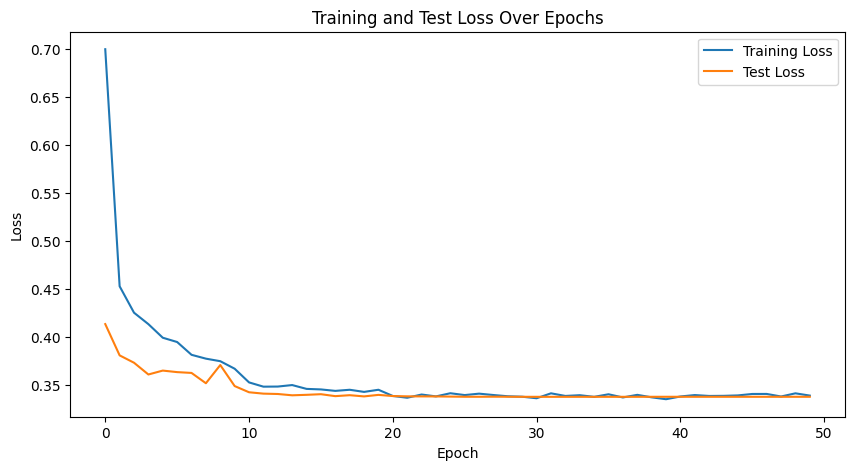

In [30]:
# Plot training and test loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()

In [ ]:
model.eval() 
with torch.no_grad():
    test_predictions = torch.argmax(model(X_test_tensor), dim=1).numpy()
    y_test_np = y_test_tensor.numpy()

accuracy = accuracy_score(y_test_np, test_predictions)
print(f"Accuracy on the test set: {accuracy:.4f}")

Accuracy on the test set: 0.8904


# Inference

In [34]:
import pandas as pd
import torch

# Define the predict function
def predict_and_generate_submission(model, test_file_path, numerical_columns, label_encoder, scaler, output_file):
    # Load the test dataset
    test_df = pd.read_csv(test_file_path)

    # Keep the ID column for the submission
    ids = test_df['id']

    # Preprocess the test data (similar to training data)
    test_df = test_df.drop(columns=['id'], errors='ignore')

    # Add the BMI feature
    if 'Weight' in test_df.columns and 'Height' in test_df.columns:
        test_df['BMI'] = test_df['Weight'] / (test_df['Height'] ** 2)
    else:
        raise ValueError("Test data must include 'Weight' and 'Height' columns to calculate BMI.")

    # Label encode binary columns
    binary_columns = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
    for col in binary_columns:
        if col in test_df.columns:
            test_df[col] = label_encoders[col].transform(test_df[col])
    
    # One-hot encode categorical columns
    one_hot_columns = ['CAEC', 'CALC', 'MTRANS']
    test_df = pd.get_dummies(test_df, columns=one_hot_columns, drop_first=True)

    # Convert boolean columns to integers
    test_df = test_df.astype({col: int for col in test_df.select_dtypes(include=['bool']).columns})

    # Align columns with the training data
    missing_cols = set(X_train.columns) - set(test_df.columns)
    for col in missing_cols:
        test_df[col] = 0  # Add missing columns as 0
    test_df = test_df[X_train.columns]  # Ensure the same column order

    # Normalize numerical columns
    test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

    # Convert to PyTorch tensor
    test_tensor = torch.tensor(test_df.values, dtype=torch.float32)

    # Predict with the model
    model.eval()
    with torch.no_grad():
        predictions = torch.argmax(model(test_tensor), dim=1).numpy()

    # Decode predictions to original class names
    predicted_labels = label_encoder.inverse_transform(predictions)

    # Create the submission DataFrame
    submission = pd.DataFrame({'id': ids, 'NObeyesdad': predicted_labels})

    # Save the submission file
    submission.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

# Call the function
predict_and_generate_submission(
    model=model,  # Trained model
    test_file_path="dataset/test.csv",  # Test file path
    numerical_columns=['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'BMI'],  # Include BMI
    label_encoder=target_encoder,  # Target encoder
    scaler=scaler,  # Scaler used during training
    output_file="submission.csv"  # Output submission file
)


Submission saved to submission.csv
